In [1]:
from matplotlib import rcParams, rc
rcParams.update({'figure.autolayout': True})

import csv
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import math
import pandas as pd

from Tarjet import *
from Phisicsparams import *
from utils import *
from MTMM import *
from tqdm import tqdm

from multiresglonet import GLOnet
from material_database import MatDatabase


In [2]:
from typing import TypeVarTuple


params = Params()
params.thickness_sup = 0.1
params.N_layers = 10

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.materials = ['Al2O3','TiO2', 'SiO2']
params.user_define = True
if params.user_define:
  params.n_min = 1.09
  params.n_max = 2.6
  params.M_discretion_n = 100
  params.M_materials = params.M_discretion_n
  params.n_database = torch.tensor(np.array([np.linspace(params.n_min,params.n_max,params.M_discretion_n)]))
else:
  pass # definirlo en otro lado
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

params.alpha_sup =  15
params.numIter = 125
params.sigma = 0.035
params.batch_size = 100
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.net = 'Res'
params.res_layers = 16                                                                             # Cantidad de bloques Residuales del bloque ResNet
params.res_dim = 256                                                                               # Cantidad de neuronas en la capa de entrada al bloque ResNet
params.noise_dim = 26                                                                              # Dimension de la Capa de entrada
params.lr = 0.05                                                                                   # Tasa de aprendizaje del optimizador Adam (learning rate)
params.beta1 = 0.9                                                                                 # Coeficiente de decaimiento para el momento del primer orden del optimizador Adam
params.beta2 = 0.99                                                                                # Coeficiente de decaimiento para el momento del segundo orden del optimizador Adam
params.weight_decay = 0.001                                                                        # Termino de decaimiento del peso para regularizar los pesos del generador durante la optimizacion
params.step_size = 40000                                                                           # Numero de epicas despues de las cuales se reduce la tasa de aprendizaje
params.gamma = 0.5                                                                                 # El factor de reduccion para la tasa de aprendizaje. Despues de cada step_size epocas, la tasa de aprendizaje se multiplica por gamma


In [3]:
params.condiciones = 2
physicsparams = PhysicsParams(params.condiciones, user_define=True)

n_interna = 1.2

physicsparams.n_bot_1 = n_interna
physicsparams.n_top_1 = 1
physicsparams.k_1 = 370
physicsparams.k_values.append(physicsparams.k_1)
physicsparams.theta_1 = 0
physicsparams.lambda_min_1 = 380
physicsparams.lambda_max_1 = 750
physicsparams.pol_1 = "TE"

physicsparams.n_bot_2 = 1
physicsparams.n_top_2 = n_interna
physicsparams.k_2 = 190
physicsparams.k_values.append(physicsparams.k_2)
physicsparams.theta_2 = 45
physicsparams.lambda_min_2 = 380
physicsparams.lambda_max_2 = 570
physicsparams.pol_2 = "TE"

physicsparams.generate_physics_params()
# physicsparams.view_attributes()

tarjet = Tarjet(params.condiciones, physicsparams.k_values, params.user_define)
tarjet.configure_targets()



In [4]:
if not params.user_define:
    params.matdatabase =  MatDatabase(params.materials)
    params.n_database = params.matdatabase.interp_wv(2 * math.pi/physicsparams.ks, params.materials, True)
    params.M_materials =  params.n_database.size(0)

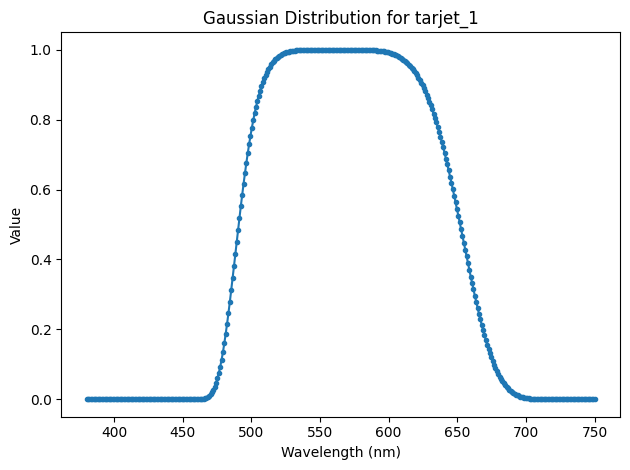

In [5]:

# Definir la función gaussiana
def gaussian(x, mean, sigma):
    return np.exp(- (x - mean) ** 6 / (2 * sigma ** 6))

# Parámetros de la distribución gaussiana
mean = 2 * math.pi / 560 * 1000  # Cambiado a 450 para que el pico esté en 450
sigma = 1.5

# Aplicar la función gaussiana a `physicsparams.k_1`
tarjet_1_gaussian = gaussian(physicsparams.k_1, mean, sigma)
tarjet.tarjets["tarjet_1"].view(-1)[:] = tarjet_1_gaussian

# Asignar los valores modificados al objeto `tarjet_1`

# Visualizar el resultado
plt.plot(2 * math.pi / physicsparams.k_1 * 1000, tarjet_1_gaussian, ".-")
plt.title('Gaussian Distribution for tarjet_1')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Value')
plt.show()


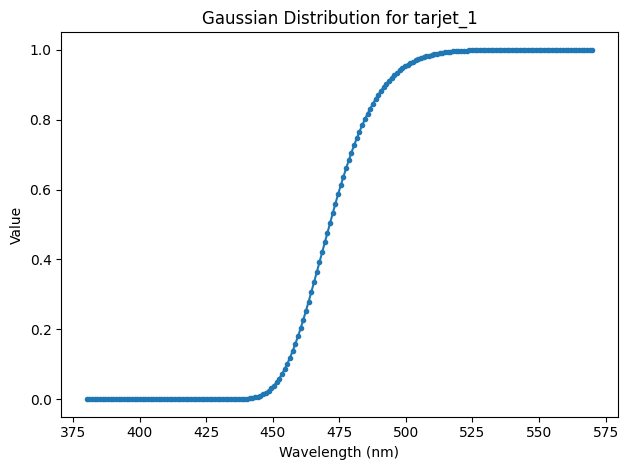

In [6]:
# Definir la función gaussiana
def gaussian(x, mean, sigma):
    return np.exp(- (x - mean) ** 6 / (2 * sigma ** 2))

# Parámetros de la distribución gaussiana


mean = 2 * math.pi / 560 * 1000  
sigma = 8
tarjet_2_gaussian = gaussian(physicsparams.k_2, mean, sigma)
tarjet.tarjets["tarjet_2"].view(-1)[:] = tarjet_2_gaussian

# Asignar los valores modificados al objeto `tarjet_1`

# Visualizar el resultado
plt.plot(2 * math.pi / physicsparams.k_2 * 1000, tarjet_2_gaussian, ".-")
plt.title('Gaussian Distribution for tarjet_1')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Value')
plt.show()

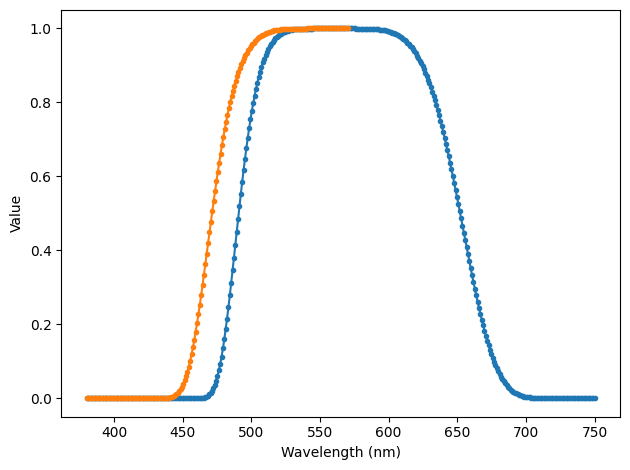

In [7]:
plt.plot(2 * math.pi / physicsparams.k_1 * 1000, tarjet_1_gaussian, ".-")
plt.plot(2 * math.pi / physicsparams.k_2 * 1000, tarjet_2_gaussian, ".-")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Value')
plt.show()

In [8]:

thicknesses_list = []
ref_idx_list = []

figures_dir = 'figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

histogram_dir = "Histogramas"
os.makedirs(histogram_dir, exist_ok=True)
    
Loss_dir =  "Losses"
if not os.path.exists(Loss_dir):
    os.makedirs(Loss_dir)

doblefiguresdir =  "Doblefigures"
if not os.path.exists(doblefiguresdir):
    os.makedirs(doblefiguresdir)
    
Error = []
Angles = []

xlim = (300, 800)
ylim = (-0.5, 1.5)
vertical_lines = [380, 495, 570, 750]

#-------------------------------------------------------------------------------------------------------

params.condiciones = 2
physicsparams = PhysicsParams(params.condiciones, user_define=True)

n_interna = 1.018

physicsparams.n_bot_1 = n_interna
physicsparams.n_top_1 = 1
physicsparams.k_1 = 370
physicsparams.k_values.append(physicsparams.k_1)
physicsparams.theta_1 = 45
physicsparams.lambda_min_1 = 380
physicsparams.lambda_max_1 = 750
physicsparams.pol_1 = "TE"

physicsparams.n_bot_2 = 1
physicsparams.n_top_2 = n_interna
physicsparams.k_2 = 190
physicsparams.k_values.append(physicsparams.k_2)
physicsparams.theta_2 = 45
physicsparams.lambda_min_2 = 380
physicsparams.lambda_max_2 = 570
physicsparams.pol_2 = "TE"

physicsparams.generate_physics_params()

#-----------------------------------------------------------------------------------------------------------
tarjet = Tarjet(params.condiciones, physicsparams.k_values, params.user_define)
tarjet.configure_targets()

mean = 2 * math.pi / 560 * 1000  
sigma = 2.5

tarjet_2_gaussian = gaussian(physicsparams.k_2, mean, sigma)
tarjet.tarjets["tarjet_2"].view(-1)[:] = tarjet_2_gaussian

tarjet_1_gaussian = gaussian(physicsparams.k_1, mean, sigma)
tarjet.tarjets["tarjet_1"].view(-1)[:] = tarjet_1_gaussian

def gaussian(x, mean, sigma):
    return np.exp(- (x - mean) ** 6 / (2 * sigma ** 6))


for seed in range(1000):      
                                              

  mean_1 = 2 * math.pi / (560 + seed* 200/1000 ) * 1000  
  mean_2 = 2 * math.pi / (560 - seed* 200/1000 ) * 1000  
  sigma = 1.5
  
  tarjet_1_gaussian = gaussian(physicsparams.k_1, mean_1, sigma)
  
  tarjet.tarjets["tarjet_1"].view(-1)[:] = tarjet_1_gaussian
  
  tarjet_2_gaussian = gaussian(physicsparams.k_2, mean_2, sigma)
  tarjet.tarjets["tarjet_2"].view(-1)[:] = tarjet_2_gaussian
  
  plt.plot(2 * math.pi / physicsparams.k_1 * 1000, tarjet_1_gaussian, ".-")
  plt.plot(2 * math.pi / physicsparams.k_2 * 1000, tarjet_2_gaussian, ".-")
  plt.xlabel('Wavelength (nm)')
  plt.ylabel('Value')
  plt.savefig(f"{doblefiguresdir}/Doblefig_{seed}.png", bbox_inches='tight')
  plt.close()
  
  torch.manual_seed(seed)
  glonet = GLOnet(params, physicsparams, tarjet)
  glonet.train()
  
  plt.figure(figsize = (20, 5))
  plt.subplot(131)
  plt.plot(glonet.loss_training)
  plt.ylabel('Loss', fontsize=18)
  plt.xlabel('Iterations', fontsize=18)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.savefig(f"{Loss_dir}/Loss_seed_{seed}.png", bbox_inches='tight')
  plt.close()
  
  print(f"iteration{seed + 1 }")

  with torch.no_grad():
      params.k_test = 2 * math.pi / torch.linspace(0.3, 2.5, 50)
      params.theta_test = torch.linspace(0, math.pi/2.25, 50)
      (thicknesses, ref_index, result_mat) = glonet.evaluate(150, kvector=params.k_test, inc_angles=params.theta_test, grayscale=True)
      # Optimizacion
      
      reflex = MTMM_solver(params.condiciones, thicknesses, ref_index, physicsparams)
      FoM_reflex_total = sum(torch.pow(reflex[f'reflexion_{i}'] - tarjet.tarjets[f'tarjet_{i}'], 2).mean(dim=[1, 2, 3]) for i in range(1, 3))
      _, indices = torch.sort(FoM_reflex_total)
      opt_idx = indices[0]
      Error.append(FoM_reflex_total[opt_idx])
      

      # Visualización del FoM total
      
      plt.figure(figsize=(10, 2))
      plt.subplot(131)
      plt.hist(FoM_reflex_total.cpu().detach().numpy(), alpha=0.5)
      plt.xlabel(f"FoM (n' = {n_interna})", fontsize=18)
      plt.xticks(fontsize=14)
      plt.yticks(fontsize=14)
      plt.savefig(f"{histogram_dir}/histograma_seed_{seed}.png", bbox_inches='tight')
      plt.close()
      
      # Encontrar el índice óptimo

      optimal_thicknesses = thicknesses[opt_idx]
      optimal_ref_idx = ref_index[opt_idx]
      
      thicknesses_list.append(optimal_thicknesses.view(-1).cpu().numpy().tolist())
      ref_idx_list.append(optimal_ref_idx.view(-1).cpu().numpy().tolist())

          
 
  fig, axs = plt.subplots(1, 2, figsize=(13, 3))  # 1 fila, 2 columnas
  fig.subplots_adjust(wspace=0.4)
  
  # Definir optimal_reflections
  optimal_reflections = {}
  
  for i in range(1, 3):  # Solo 1 y 2
      reflex_key = f'reflexion_{i}'
      optimal_reflections[reflex_key] = reflex[reflex_key][opt_idx]
      
      # Gráfico de reflexión óptima
      axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                    optimal_reflections[f'reflexion_{i}'][:, 0, 0].detach().numpy(),
                    "-", color="violet", label="Optimal Reflexion")
  
      # Gráfico de reflexión de tarjeta
      tarjet_color = "red" if i == 1 else "green"
      axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                    tarjet.tarjets[f"tarjet_{i}"].view(-1),
                    ".-", color=tarjet_color, label=f"Tarjet Reflexion {i}", markersize=2.5)
  
      axs[i-1].set_xlabel("Wavelength (nm)", fontsize=16)
      axs[i-1].set_ylabel("Reflection", fontsize=16)
      axs[i-1].legend(fontsize=10)
      axs[i-1].set_title(f"Reflexion {i}", fontsize=20)
      axs[i-1].tick_params(axis='both', which='major', labelsize=14)
      axs[i-1].set_xlim(xlim)
      axs[i-1].set_ylim(ylim)

          
  fig.savefig(os.path.join(figures_dir, f"reflexion_seed_{seed}.png"))
  plt.close(fig)

with open('optimal_thicknesses.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(thicknesses_list)

# Archivo CSV para los índices de refracción
with open('optimal_ref_idx.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(ref_idx_list)


with open('Error.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(Error)


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration1


100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


iteration2


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration3


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration4


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


iteration5


100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


iteration6


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


iteration7


100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


iteration8


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration9


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration10


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration11


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration12


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration13


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration14


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration15


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration16


100%|██████████| 125/125 [01:12<00:00,  1.71it/s]


iteration17


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration18


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration19


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration20


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration21


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration22


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration23


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration24


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration25


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration26


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration27


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration28


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration29


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration30


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration31


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration32


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration33


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration34


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration35


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration36


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration37


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration38


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration39


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration40


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration41


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration42


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


iteration43


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration44


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration45


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration46


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration47


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration48


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration49


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration50


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration51


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration52


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration53


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration54


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration55


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration56


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration57


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration58


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration59


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration60


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration61


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration62


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration63


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration64


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration65


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration66


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration67


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration68


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration69


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration70


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration71


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration72


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration73


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration74


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration75


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration76


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration77


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration78


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration79


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration80


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration81


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration82


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration83


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration84


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration85


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration86


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration87


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration88


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration89


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration90


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration91


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration92


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration93


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration94


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration95


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration96


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration97


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration98


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration99


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration100


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration101


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration102


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration103


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration104


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration105


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration106


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration107


100%|██████████| 125/125 [01:07<00:00,  1.87it/s]


iteration108


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration109


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration110


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration111


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration112


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration113


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration114


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration115


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration116


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration117


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration118


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration119


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration120


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration121


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration122


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration123


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration124


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration125


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration126


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration127


100%|██████████| 125/125 [01:10<00:00,  1.79it/s]


iteration128


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration129


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration130


100%|██████████| 125/125 [01:10<00:00,  1.79it/s]


iteration131


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration132


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration133


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration134


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration135


100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


iteration136


100%|██████████| 125/125 [01:49<00:00,  1.14it/s]


iteration137


100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


iteration138


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration139


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration140


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration141


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration142


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration143


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration144


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration145


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration146


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration147


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration148


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration149


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration150


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration151


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration152


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration153


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration154


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration155


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration156


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration157


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration158


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration159


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration160


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration161


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration162


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration163


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration164


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration165


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration166


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration167


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration168


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration169


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration170


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration171


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration172


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration173


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration174


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration175


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration176


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration177


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration178


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration179


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration180


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration181


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration182


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration183


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration184


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration185


100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


iteration186


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration187


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration188


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration189


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration190


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration191


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration192


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration193


100%|██████████| 125/125 [01:11<00:00,  1.76it/s]


iteration194


100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


iteration195


100%|██████████| 125/125 [01:10<00:00,  1.79it/s]


iteration196


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration197


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration198


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration199


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration200


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration201


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration202


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration203


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration204


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration205


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration206


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration207


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration208


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration209


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration210


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration211


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration212


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration213


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration214


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration215


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration216


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration217


100%|██████████| 125/125 [01:12<00:00,  1.71it/s]


iteration218


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration219


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration220


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration221


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration222


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration223


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration224


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration225


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration226


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration227


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration228


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration229


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration230


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration231


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration232


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration233


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration234


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration235


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration236


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration237


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration238


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration239


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration240


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration241


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration242


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration243


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration244


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration245


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration246


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration247


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration248


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration249


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration250


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration251


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration252


100%|██████████| 125/125 [01:02<00:00,  2.02it/s]


iteration253


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration254


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration255


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration256


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration257


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration258


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration259


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration260


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration261


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration262


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration263


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration264


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration265


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration266


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration267


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration268


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration269


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration270


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration271


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration272


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration273


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration274


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration275


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration276


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration277


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration278


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration279


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration280


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration281


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration282


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration283


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration284


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration285


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration286


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration287


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration288


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration289


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration290


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration291


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration292


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration293


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration294


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration295


100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


iteration296


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration297


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration298


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration299


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration300


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration301


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration302


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration303


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration304


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration305


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration306


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration307


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration308


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration309


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration310


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration311


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration312


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration313


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration314


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration315


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration316


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration317


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration318


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration319


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


iteration320


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration321


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration322


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration323


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration324


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration325


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration326


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration327


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration328


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration329


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration330


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration331


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration332


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration333


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration334


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration335


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration336


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration337


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration338


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration339


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration340


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration341


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration342


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration343


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration344


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration345


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration346


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration347


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration348


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration349


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration350


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration351


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration352


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration353


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration354


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration355


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration356


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration357


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration358


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration359


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration360


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration361


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration362


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration363


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration364


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration365


100%|██████████| 125/125 [01:02<00:00,  2.02it/s]


iteration366


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration367


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration368


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration369


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration370


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration371


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration372


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration373


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration374


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration375


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration376


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration377


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration378


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration379


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration380


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration381


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration382


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration383


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration384


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration385


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration386


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration387


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration388


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration389


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration390


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration391


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration392


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration393


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration394


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration395


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration396


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration397


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration398


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration399


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration400


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration401


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration402


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration403


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration404


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration405


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration406


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration407


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration408


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration409


100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


iteration410


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration411


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration412


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration413


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration414


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration415


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration416


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration417


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration418


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration419


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration420


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration421


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration422


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration423


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration424


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration425


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration426


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration427


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration428


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


iteration429


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration430


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration431


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration432


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration433


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration434


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration435


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration436


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration437


100%|██████████| 125/125 [01:02<00:00,  2.02it/s]


iteration438


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration439


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration440


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration441


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration442


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration443


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration444


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration445


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration446


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration447


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration448


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration449


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration450


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration451


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration452


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration453


100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


iteration454


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration455


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration456


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration457


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration458


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration459


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration460


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration461


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration462


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration463


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration464


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration465


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration466


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration467


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration468


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration469


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration470


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration471


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration472


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration473


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration474


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration475


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration476


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration477


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration478


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration479


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration480


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration481


100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


iteration482


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration483


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration484


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration485


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration486


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration487


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration488


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration489


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration490


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration491


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration492


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration493


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration494


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration495


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration496


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration497


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration498


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration499


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration500


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration501


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration502


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration503


100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


iteration504


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration505


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration506


100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


iteration507


100%|██████████| 125/125 [25:29<00:00, 12.24s/it] 


iteration508


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration509


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration510


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration511


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration512


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration513


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration514


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration515


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration516


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration517


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration518


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration519


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration520


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration521


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration522


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration523


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration524


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration525


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration526


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration527


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration528


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration529


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration530


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration531


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration532


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration533


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration534


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration535


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration536


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration537


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration538


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration539


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration540


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration541


100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


iteration542


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration543


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration544


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration545


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration546


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration547


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration548


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration549


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration550


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration551


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration552


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration553


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration554


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration555


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration556


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration557


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration558


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration559


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration560


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration561


100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


iteration562


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration563


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration564


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration565


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration566


100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


iteration567


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration568


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration569


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration570


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration571


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration572


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration573


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration574


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration575


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration576


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration577


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration578


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration579


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration580


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration581


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration582


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration583


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration584


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration585


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration586


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration587


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration588


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration589


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


iteration590


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration591


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration592


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration593


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration594


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration595


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration596


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration597


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration598


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration599


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration600


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration601


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration602


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration603


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration604


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration605


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration606


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration607


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration608


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration609


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration610


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration611


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration612


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration613


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration614


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration615


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration616


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration617


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration618


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration619


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration620


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration621


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration622


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration623


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration624


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration625


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration626


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration627


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration628


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration629


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration630


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration631


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration632


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration633


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration634


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration635


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration636


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration637


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration638


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration639


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration640


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration641


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration642


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration643


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration644


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


iteration645


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration646


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration647


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration648


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration649


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration650


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration651


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration652


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration653


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration654


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration655


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration656


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration657


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration658


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


iteration659


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration660


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration661


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration662


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration663


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration664


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration665


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration666


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration667


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration668


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration669


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration670


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration671


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration672


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration673


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration674


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration675


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration676


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration677


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration678


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration679


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration680


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration681


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration682


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration683


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration684


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration685


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration686


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration687


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration688


100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


iteration689


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration690


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration691


100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


iteration692


100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


iteration693


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration694


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration695


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration696


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration697


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration698


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration699


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration700


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration701


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration702


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration703


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration704


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration705


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration706


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration707


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration708


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration709


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration710


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration711


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration712


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration713


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration714


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration715


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration716


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration717


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration718


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration719


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration720


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration721


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration722


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration723


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration724


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration725


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration726


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration727


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration728


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration729


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration730


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration731


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration732


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration733


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration734


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration735


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration736


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration737


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration738


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration739


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration740


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration741


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration742


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration743


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration744


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration745


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


iteration746


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration747


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration748


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration749


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration750


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration751


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration752


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration753


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration754


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration755


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration756


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration757


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration758


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


iteration759


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration760


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


iteration761


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration762


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration763


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration764


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration765


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration766


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration767


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


iteration768


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration769


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration770


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration771


100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


iteration772


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration773


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


iteration774


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


iteration775


100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


iteration776


100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


iteration777


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration778


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration779


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration780


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration781


100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


iteration782


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration783


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration784


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration785


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration786


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


iteration787


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration788


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration789


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration790


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration791


100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


iteration792


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration793


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration794


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration795


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration796


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration797


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


iteration798


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


iteration799


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


iteration800


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


iteration801


100%|██████████| 125/125 [01:17<00:00,  1.61it/s]


iteration802


100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


iteration803


100%|██████████| 125/125 [01:14<00:00,  1.69it/s]


iteration804


100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


iteration805


100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


iteration806


100%|██████████| 125/125 [01:14<00:00,  1.69it/s]


iteration807


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration808


100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


iteration809


100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


iteration810


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


iteration811


100%|██████████| 125/125 [01:12<00:00,  1.74it/s]


iteration812


100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


iteration813


100%|██████████| 125/125 [01:14<00:00,  1.69it/s]


iteration814


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


iteration815


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


iteration816


100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


iteration817


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


iteration818


100%|██████████| 125/125 [01:12<00:00,  1.74it/s]


iteration819


100%|██████████| 125/125 [01:11<00:00,  1.76it/s]


iteration820


100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


iteration821


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration822


100%|██████████| 125/125 [01:32<00:00,  1.34it/s]


iteration823


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


iteration824


100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


iteration825


100%|██████████| 125/125 [01:20<00:00,  1.55it/s]


iteration826


100%|██████████| 125/125 [01:24<00:00,  1.49it/s]


iteration827


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


iteration828


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration829


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration830


100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


iteration831


100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


iteration832


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration833


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration834


100%|██████████| 125/125 [01:50<00:00,  1.13it/s]


iteration835


100%|██████████| 125/125 [04:01<00:00,  1.93s/it]


iteration836


100%|██████████| 125/125 [03:01<00:00,  1.45s/it]


iteration837


100%|██████████| 125/125 [08:14<00:00,  3.96s/it]


iteration838


100%|██████████| 125/125 [16:51<00:00,  8.10s/it]


iteration839


100%|██████████| 125/125 [06:13<00:00,  2.99s/it]


iteration840


100%|██████████| 125/125 [14:15<00:00,  6.84s/it]


iteration841


100%|██████████| 125/125 [06:13<00:00,  2.99s/it]


iteration842


100%|██████████| 125/125 [05:18<00:00,  2.55s/it]


iteration843


100%|██████████| 125/125 [04:59<00:00,  2.39s/it]


iteration844


100%|██████████| 125/125 [04:49<00:00,  2.32s/it]


iteration845


100%|██████████| 125/125 [03:47<00:00,  1.82s/it]


iteration846


100%|██████████| 125/125 [03:51<00:00,  1.86s/it]


iteration847


100%|██████████| 125/125 [03:41<00:00,  1.78s/it]


iteration848


100%|██████████| 125/125 [03:38<00:00,  1.75s/it]


iteration849


100%|██████████| 125/125 [03:49<00:00,  1.84s/it]


iteration850


100%|██████████| 125/125 [03:43<00:00,  1.79s/it]


iteration851


100%|██████████| 125/125 [03:40<00:00,  1.76s/it]


iteration852


100%|██████████| 125/125 [03:39<00:00,  1.75s/it]


iteration853


100%|██████████| 125/125 [03:42<00:00,  1.78s/it]


iteration854


100%|██████████| 125/125 [03:43<00:00,  1.79s/it]


iteration855


100%|██████████| 125/125 [03:40<00:00,  1.76s/it]


iteration856


100%|██████████| 125/125 [06:09<00:00,  2.95s/it]


iteration857


100%|██████████| 125/125 [04:30<00:00,  2.16s/it]


iteration858


100%|██████████| 125/125 [05:07<00:00,  2.46s/it]


iteration859


100%|██████████| 125/125 [04:29<00:00,  2.15s/it]


iteration860


100%|██████████| 125/125 [04:00<00:00,  1.92s/it]


iteration861


100%|██████████| 125/125 [03:20<00:00,  1.61s/it]


iteration862


100%|██████████| 125/125 [03:33<00:00,  1.71s/it]


iteration863


100%|██████████| 125/125 [03:40<00:00,  1.77s/it]


iteration864


100%|██████████| 125/125 [03:18<00:00,  1.59s/it]


iteration865


100%|██████████| 125/125 [03:07<00:00,  1.50s/it]


iteration866


100%|██████████| 125/125 [03:23<00:00,  1.63s/it]


iteration867


100%|██████████| 125/125 [06:25<00:00,  3.08s/it]


iteration868


100%|██████████| 125/125 [04:58<00:00,  2.39s/it]


iteration869


100%|██████████| 125/125 [04:23<00:00,  2.11s/it]


iteration870


100%|██████████| 125/125 [01:18<00:00,  1.59it/s]


iteration871


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration872


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration873


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration874


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration875


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration876


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration877


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration878


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration879


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration880


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration881


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration882


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration883


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration884


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


iteration885


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration886


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration887


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration888


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration889


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration890


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration891


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration892


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration893


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration894


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration895


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration896


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration897


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration898


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration899


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration900


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration901


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration902


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration903


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration904


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration905


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration906


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration907


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration908


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration909


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration910


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration911


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration912


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration913


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration914


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration915


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration916


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration917


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration918


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration919


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


iteration920


100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


iteration921


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration922


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration923


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration924


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration925


100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


iteration926


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration927


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration928


100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


iteration929


100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


iteration930


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration931


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration932


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration933


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration934


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration935


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration936


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration937


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration938


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration939


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration940


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration941


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration942


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration943


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration944


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration945


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration946


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration947


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration948


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration949


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration950


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration951


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration952


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration953


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration954


100%|██████████| 125/125 [01:11<00:00,  1.76it/s]


iteration955


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration956


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration957


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration958


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


iteration959


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration960


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration961


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration962


100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


iteration963


100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


iteration964


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration965


100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


iteration966


100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


iteration967


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration968


100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


iteration969


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration970


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration971


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


iteration972


100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


iteration973


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration974


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration975


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration976


100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


iteration977


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration978


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration979


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration980


100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


iteration981


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration982


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration983


100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


iteration984


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration985


100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


iteration986


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration987


100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


iteration988


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration989


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration990


100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


iteration991


100%|██████████| 125/125 [01:08<00:00,  1.81it/s]


iteration992


100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


iteration993


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


iteration994


100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


iteration995


100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


iteration996


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration997


100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


iteration998


100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


iteration999


100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


iteration1000


Error: iterable expected, not Tensor

In [ ]:
Angles = [0.0,
 0.085,
 0.17,
 0.255,
 0.34,
 0.425,
 0.51,
 0.595,
 0.68,
 0.765,
 0.85,
 0.935,
 1.02,
 1.105,
 1.19,
 1.275,
 1.36,
 1.445,
 1.53,
 1.615,
 1.7,
 1.785,
 1.87,
 1.955,
 2.04,
 2.125,
 2.21,
 2.295,
 2.38,
 2.465,
 2.55,
 2.635,
 2.72,
 2.805,
 2.89,
 2.975,
 3.06,
 3.145,
 3.23,
 3.315,
 3.4,
 3.485,
 3.57,
 3.655,
 3.74,
 3.825,
 3.91,
 3.995,
 4.08,
 4.165,
 4.25,
 4.335,
 4.42,
 4.505,
 4.59,
 4.675,
 4.76,
 4.845,
 4.93,
 5.015,
 5.1,
 5.185,
 5.27,
 5.355,
 5.44,
 5.525,
 5.61,
 5.695,
 5.78,
 5.865,
 5.95,
 6.035,
 6.12,
 6.205,
 6.29,
 6.375,
 6.46,
 6.545,
 6.63,
 6.715,
 6.8,
 6.885,
 6.97,
 7.055,
 7.14,
 7.225,
 7.31,
 7.395,
 7.48,
 7.565,
 7.65,
 7.735,
 7.82,
 7.905,
 7.99,
 8.075,
 8.16,
 8.245,
 8.33,
 8.415,
 8.5,
 8.585,
 8.67,
 8.755,
 8.84,
 8.925,
 9.01,
 9.095,
 9.18,
 9.265,
 9.35,
 9.435,
 9.52,
 9.605,
 9.69,
 9.775,
 9.86,
 9.945,
 10.03,
 10.115,
 10.2,
 10.285,
 10.37,
 10.455,
 10.54,
 10.625,
 10.71,
 10.795,
 10.88,
 10.965,
 11.05,
 11.135,
 11.22,
 11.305,
 11.39,
 11.475,
 11.56,
 11.645,
 11.73,
 11.815,
 11.9,
 11.985,
 12.07,
 12.155,
 12.24,
 12.325,
 12.41,
 12.495,
 12.58,
 12.665,
 12.75,
 12.835,
 12.92,
 13.005,
 13.09,
 13.175,
 13.26,
 13.345,
 13.43,
 13.515,
 13.6,
 13.685,
 13.77,
 13.855,
 13.94,
 14.025,
 14.11,
 14.195,
 14.28,
 14.365,
 14.45,
 14.535,
 14.62,
 14.705,
 14.79,
 14.875,
 14.96,
 15.045,
 15.13,
 15.215,
 15.3,
 15.385,
 15.47,
 15.555,
 15.64,
 15.725,
 15.81,
 15.895,
 15.98,
 16.065,
 16.15,
 16.235,
 16.32,
 16.405,
 16.49,
 16.575,
 16.66,
 16.745,
 16.83,
 16.915,
 17.0,
 17.085,
 17.17,
 17.255,
 17.34,
 17.425,
 17.51,
 17.595,
 17.68,
 17.765,
 17.85,
 17.935,
 18.02,
 18.105,
 18.19,
 18.275,
 18.36,
 18.445,
 18.53,
 18.615,
 18.7,
 18.785,
 18.87,
 18.955,
 19.04,
 19.125,
 19.21,
 19.295,
 19.38,
 19.465,
 19.55,
 19.635,
 19.72,
 19.805,
 19.89,
 19.975,
 20.06,
 20.145,
 20.23,
 20.315,
 20.4,
 20.485,
 20.57,
 20.655,
 20.74,
 20.825,
 20.91,
 20.995,
 21.08,
 21.165,
 21.25,
 21.335,
 21.42,
 21.505,
 21.59,
 21.675,
 21.76,
 21.845,
 21.93,
 22.015,
 22.1,
 22.185,
 22.27,
 22.355,
 22.44,
 22.525,
 22.61,
 22.695,
 22.78,
 22.865,
 22.95,
 23.035,
 23.12,
 23.205,
 23.29,
 23.375,
 23.46,
 23.545,
 23.63,
 23.715,
 23.8,
 23.885,
 23.97,
 24.055,
 24.14,
 24.225,
 24.31,
 24.395,
 24.48,
 24.565,
 24.65,
 24.735,
 24.82,
 24.905,
 24.99,
 25.075,
 25.16,
 25.245,
 25.33,
 25.415,
 25.5,
 25.585,
 25.67,
 25.755,
 25.84,
 25.925,
 26.01,
 26.095,
 26.18,
 26.265,
 26.35,
 26.435,
 26.52,
 26.605,
 26.69,
 26.775,
 26.86,
 26.945,
 27.03,
 27.115,
 27.2,
 27.285,
 27.37,
 27.455,
 27.54,
 27.625,
 27.71,
 27.795,
 27.88,
 27.965,
 28.05,
 28.135,
 28.22,
 28.305,
 28.39,
 28.475,
 28.56,
 28.645,
 28.73,
 28.815,
 28.9,
 28.985,
 29.07,
 29.155,
 29.24,
 29.325,
 29.41,
 29.495,
 29.58,
 29.665,
 29.75,
 29.835,
 29.92,
 30.005,
 30.09,
 30.175,
 30.26,
 30.345,
 30.43,
 30.515,
 30.6,
 30.685,
 30.77,
 30.855,
 30.94,
 31.025,
 31.11,
 31.195,
 31.28,
 31.365,
 31.45,
 31.535,
 31.62,
 31.705,
 31.79,
 31.875,
 31.96,
 32.045,
 32.13,
 32.215,
 32.3,
 32.385,
 32.47,
 32.555,
 32.64,
 32.725,
 32.81,
 32.895,
 32.98,
 33.065,
 33.15,
 33.235,
 33.32,
 33.405,
 33.49,
 33.575,
 33.66,
 33.745,
 33.83,
 33.915,
 34.0,
 34.085,
 34.17,
 34.255,
 34.34,
 34.425,
 34.51,
 34.595,
 34.68,
 34.765,
 34.85,
 34.935,
 35.02,
 35.105,
 35.19,
 35.275,
 35.36,
 35.445,
 35.53,
 35.615,
 35.7,
 35.785,
 35.87,
 35.955,
 36.04,
 36.125,
 36.21,
 36.295,
 36.38,
 36.465,
 36.55,
 36.635,
 36.72,
 36.805,
 36.89,
 36.975,
 37.06,
 37.145,
 37.23,
 37.315,
 37.4,
 37.485,
 37.57,
 37.655,
 37.74,
 37.825,
 37.91,
 37.995,
 38.08,
 38.165,
 38.25,
 38.335,
 38.42,
 38.505,
 38.59,
 38.675,
 38.76,
 38.845,
 38.93,
 39.015,
 39.1,
 39.185,
 39.27,
 39.355,
 39.44,
 39.525,
 39.61,
 39.695,
 39.78,
 39.865,
 39.95,
 40.035,
 40.12,
 40.205,
 40.29,
 40.375,
 40.46,
 40.545,
 40.63,
 40.715,
 40.8,
 40.885,
 40.97,
 41.055,
 41.14,
 41.225,
 41.31,
 41.395,
 41.48,
 41.565,
 41.65,
 41.735,
 41.82,
 41.905,
 41.99,
 42.075,
 42.16,
 42.245,
 42.33,
 42.415,
 42.5,
 42.585,
 42.67,
 42.755,
 42.84,
 42.925,
 43.01,
 43.095,
 43.18,
 43.265,
 43.35,
 43.435,
 43.52,
 43.605,
 43.69,
 43.775,
 43.86,
 43.945,
 44.03,
 44.115,
 44.2,
 44.285,
 44.37,
 44.455,
 44.54,
 44.625,
 44.71,
 44.795,
 44.88,
 44.965,
 45.05,
 45.135,
 45.22,
 45.305,
 45.39,
 45.475,
 45.56,
 45.645,
 45.73,
 45.815,
 45.9,
 45.985,
 46.07,
 46.155,
 46.24,
 46.325,
 46.41,
 46.495,
 46.58,
 46.665,
 46.75,
 46.835,
 46.92,
 47.005,
 47.09,
 47.175,
 47.26,
 47.345,
 47.43,
 47.515,
 47.6,
 47.685,
 47.77,
 47.855,
 47.94,
 48.025,
 48.11,
 48.195,
 48.28,
 48.365,
 48.45,
 48.535,
 48.62,
 48.705,
 48.79,
 48.875,
 48.96,
 49.045,
 49.13,
 49.215,
 49.3,
 49.385,
 49.47,
 49.555,
 49.64,
 49.725,
 49.81,
 49.895,
 49.98,
 50.065,
 50.15,
 50.235,
 50.32,
 50.405,
 50.49,
 50.575,
 50.66,
 50.745,
 50.83,
 50.915,
 51.0,
 51.085,
 51.17,
 51.255,
 51.34,
 51.425,
 51.51,
 51.595,
 51.68,
 51.765,
 51.85,
 51.935,
 52.02,
 52.105,
 52.19,
 52.275,
 52.36,
 52.445,
 52.53,
 52.615,
 52.7,
 52.785,
 52.87,
 52.955,
 53.04,
 53.125,
 53.21,
 53.295,
 53.38,
 53.465,
 53.55,
 53.635,
 53.72,
 53.805,
 53.89,
 53.975,
 54.06,
 54.145,
 54.23,
 54.315,
 54.4,
 54.485,
 54.57,
 54.655,
 54.74,
 54.825,
 54.91,
 54.995,
 55.08,
 55.165,
 55.25,
 55.335,
 55.42,
 55.505,
 55.59,
 55.675,
 55.76,
 55.845,
 55.93,
 56.015,
 56.1,
 56.185,
 56.27,
 56.355,
 56.44,
 56.525,
 56.61,
 56.695,
 56.78,
 56.865,
 56.95,
 57.035,
 57.12,
 57.205,
 57.29,
 57.375,
 57.46,
 57.545,
 57.63,
 57.715,
 57.8,
 57.885,
 57.97,
 58.055,
 58.14,
 58.225,
 58.31,
 58.395,
 58.48,
 58.565,
 58.65,
 58.735,
 58.82,
 58.905,
 58.99,
 59.075,
 59.16,
 59.245,
 59.33,
 59.415,
 59.5,
 59.585,
 59.67,
 59.755,
 59.84,
 59.925,
 60.01,
 60.095,
 60.18,
 60.265,
 60.35,
 60.435,
 60.52,
 60.605,
 60.69,
 60.775,
 60.86,
 60.945,
 61.03,
 61.115,
 61.2,
 61.285,
 61.37,
 61.455,
 61.54,
 61.625,
 61.71,
 61.795,
 61.88,
 61.965,
 62.05,
 62.135,
 62.22,
 62.305,
 62.39,
 62.475,
 62.56,
 62.645,
 62.73,
 62.815,
 62.9,
 62.985,
 63.07,
 63.155,
 63.24,
 63.325,
 63.41,
 63.495,
 63.58,
 63.665,
 63.75,
 63.835,
 63.92,
 64.005,
 64.09,
 64.175,
 64.26,
 64.345,
 64.43,
 64.515,
 64.6,
 64.685,
 64.77,
 64.855,
 64.94,
 65.025,
 65.11,
 65.195,
 65.28,
 65.365,
 65.45,
 65.535,
 65.62,
 65.705,
 65.79,
 65.875,
 65.96,
 66.045,
 66.13,
 66.215,
 66.3,
 66.385,
 66.47,
 66.555,
 66.64,
 66.725,
 66.81,
 66.895,
 66.98,
 67.065,
 67.15,
 67.235,
 67.32,
 67.405,
 67.49,
 67.575,
 67.66,
 67.745,
 67.83,
 67.915,
 68.0,
 68.085,
 68.17,
 68.255,
 68.34,
 68.425,
 68.51,
 68.595,
 68.68,
 68.765,
 68.85,
 68.935,
 69.02,
 69.105,
 69.19,
 69.275,
 69.36,
 69.445,
 69.53,
 69.615,
 69.7,
 69.785,
 69.87,
 69.955,
 70.04,
 70.125,
 70.21,
 70.295,
 70.38,
 70.465,
 70.55,
 70.635,
 70.72,
 70.805,
 70.89,
 70.975,
 71.06,
 71.145,
 71.23,
 71.315,
 71.4,
 71.485,
 71.57,
 71.655,
 71.74,
 71.825,
 71.91,
 71.995,
 72.08,
 72.165,
 72.25,
 72.335,
 72.42,
 72.505,
 72.59,
 72.675,
 72.76,
 72.845,
 72.93,
 73.015,
 73.1,
 73.185,
 73.27,
 73.355,
 73.44,
 73.525,
 73.61,
 73.695,
 73.78,
 73.865,
 73.95,
 74.035,
 74.12,
 74.205,
 74.29,
 74.375,
 74.46,
 74.545,
 74.63,
 74.715,
 74.8,
 74.885,
 74.97,
 75.055,
 75.14,
 75.225,
 75.31,
 75.395,
 75.48,
 75.565,
 75.65,
 75.735,
 75.82,
 75.905,
 75.99,
 76.075,
 76.16,
 76.245,
 76.33,
 76.415,
 76.5,
 76.585,
 76.67,
 76.755,
 76.84,
 76.925,
 77.01,
 77.095,
 77.18,
 77.265,
 77.35,
 77.435,
 77.52,
 77.605,
 77.69,
 77.775,
 77.86,
 77.945,
 78.03,
 78.115,
 78.2,
 78.285,
 78.37,
 78.455,
 78.54,
 78.625,
 78.71,
 78.795,
 78.88,
 78.965,
 79.05,
 79.135,
 79.22,
 79.305,
 79.39,
 79.475,
 79.56,
 79.645,
 79.73,
 79.815,
 79.9,
 79.985,
 80.07,
 80.155,
 80.24,
 80.325,
 80.41,
 80.495,
 80.58,
 80.665,
 80.75,
 80.835,
 80.92,
 81.005,
 81.09,
 81.175,
 81.26,
 81.345,
 81.43,
 81.515,
 81.6,
 81.685,
 81.77,
 81.855,
 81.94,
 82.025,
 82.11,
 82.195,
 82.28,
 82.365,
 82.45,
 82.535,
 82.62,
 82.705,
 82.79,
 82.875,
 82.96,
 83.045,
 83.13,
 83.215,
 83.3,
 83.385,
 83.47,
 83.555,
 83.64,
 83.725,
 83.81,
 83.895,
 83.98,
 84.065,
 84.15,
 84.235,
 84.32,
 84.405,
 84.49,
 84.575,
 84.66,
 84.745,
 84.83,
 84.915]

In [11]:
print(Error)

[tensor(0.0417, dtype=torch.float64), tensor(0.0366, dtype=torch.float64), tensor(0.0227, dtype=torch.float64), tensor(0.0378, dtype=torch.float64), tensor(0.0367, dtype=torch.float64), tensor(0.0357, dtype=torch.float64), tensor(0.0365, dtype=torch.float64), tensor(0.0232, dtype=torch.float64), tensor(0.0374, dtype=torch.float64), tensor(0.0363, dtype=torch.float64), tensor(0.0352, dtype=torch.float64), tensor(0.1377, dtype=torch.float64), tensor(0.0388, dtype=torch.float64), tensor(0.0357, dtype=torch.float64), tensor(0.0347, dtype=torch.float64), tensor(0.0389, dtype=torch.float64), tensor(0.0077, dtype=torch.float64), tensor(0.0344, dtype=torch.float64), tensor(0.0578, dtype=torch.float64), tensor(0.0344, dtype=torch.float64), tensor(0.0375, dtype=torch.float64), tensor(0.0335, dtype=torch.float64), tensor(0.0164, dtype=torch.float64), tensor(0.0976, dtype=torch.float64), tensor(0.0364, dtype=torch.float64), tensor(0.0131, dtype=torch.float64), tensor(0.0332, dtype=torch.float64), 

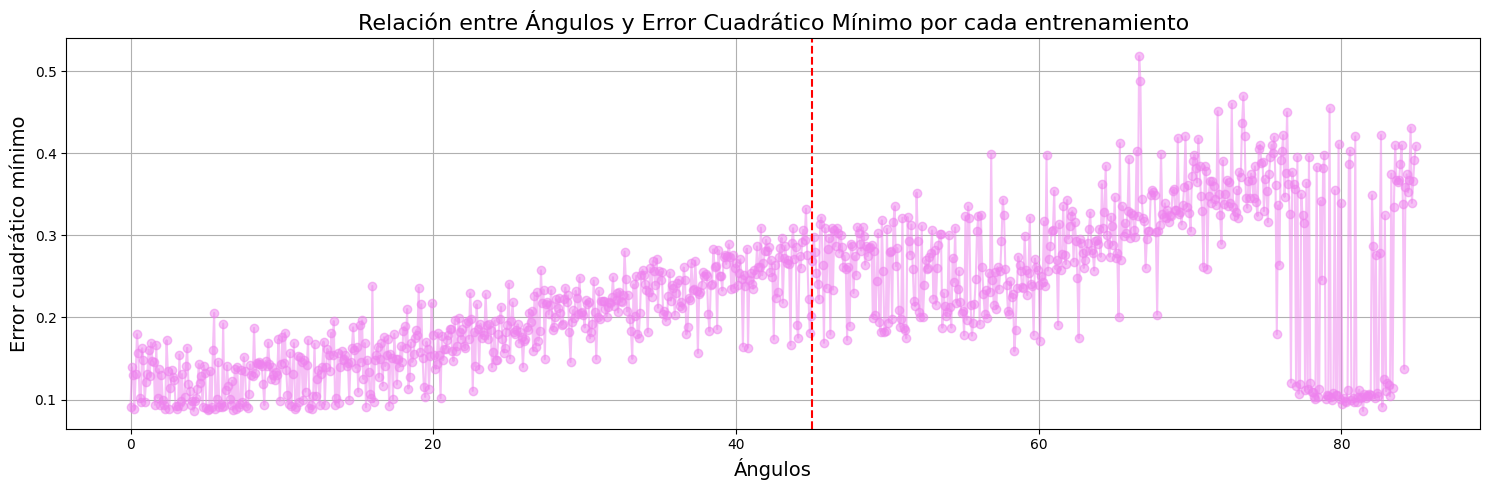

In [5]:
from pyparsing import alphas


plt.figure(figsize=(15, 5))  # Ajusta el tamaño de la figura (ancho x alto)
plt.plot(Angles, Error, "o-", color ="violet", alpha = 0.5)

plt.xlabel("Ángulos", fontsize=14)  # Ajusta el tamaño de la fuente del eje x
plt.ylabel("Error cuadrático mínimo", fontsize=14)  # Ajusta el tamaño de la fuente del eje y
plt.axvline(x=45, linestyle='--', color='Red')
plt.title("Relación entre Ángulos y Error Cuadrático Mínimo por cada entrenamiento", fontsize=16)  # Añade un título y ajusta el tamaño de la fuente

plt.grid(True)  # Opcional: Añade una cuadrícula para mayor claridad

plt.show()

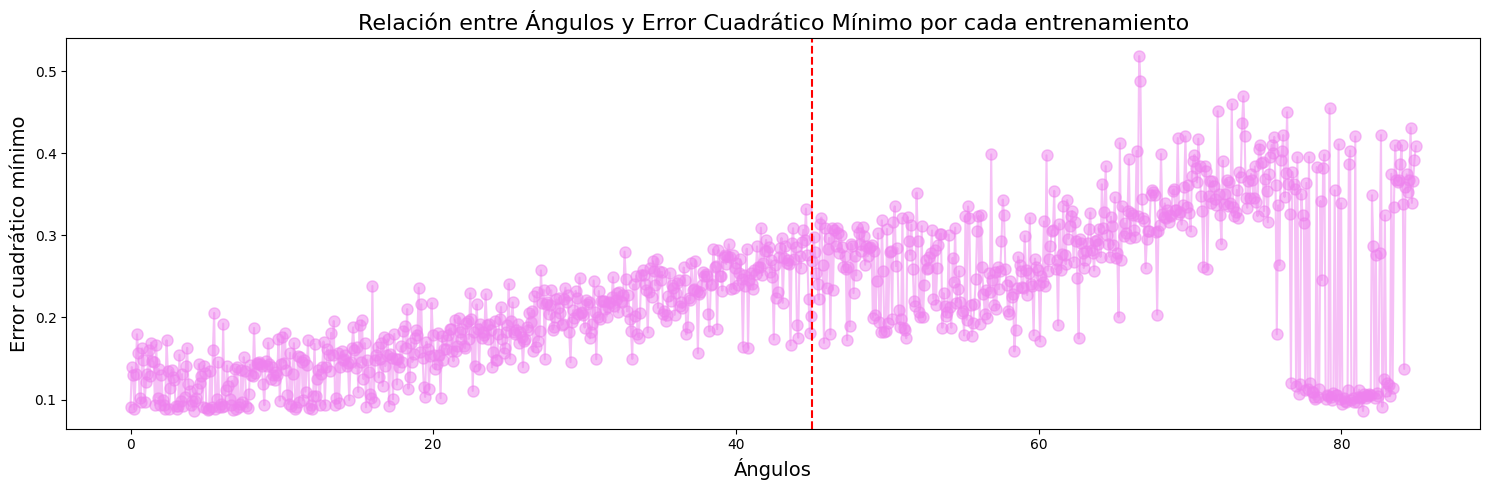

In [6]:
plt.figure(figsize=(15, 5))  # Ajusta el tamaño de la figura (ancho x alto)
plt.plot(Angles, Error, "o-", color ="violet", alpha = 0.5, markersize=8)  # Tamaño de los marcadores ajustado

plt.xlabel("Ángulos", fontsize=14)  # Ajusta el tamaño de la fuente del eje x
plt.ylabel("Error cuadrático mínimo", fontsize=14)  # Ajusta el tamaño de la fuente del eje y
plt.axvline(x=45, linestyle='--', color='Red')  # Línea vertical en x=45
plt.title("Relación entre Ángulos y Error Cuadrático Mínimo por cada entrenamiento", fontsize=16)  # Añade un título

plt.grid(False)  # Si prefieres no mostrar la cuadrícula, cambia a False o comenta esta línea

plt.show()


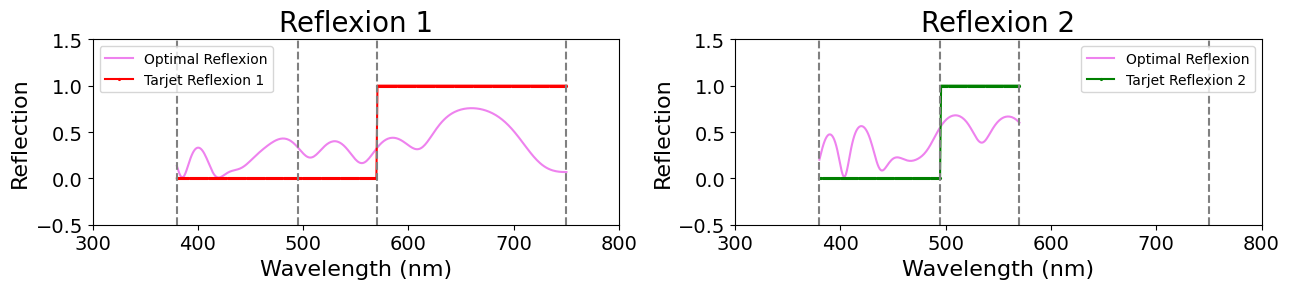

Espesores: tensor([0.0992, 0.1104, 0.1289, 0.1207, 0.0979, 0.0833, 0.0679, 0.1032, 0.0754,
        0.0453, 0.0440, 0.0413, 0.0835, 0.0592, 0.0855, 0.0350, 0.0551, 0.0564,
        0.0649, 0.1078, 0.1238, 0.0888, 0.0673, 0.0722, 0.0759])
Índices de refracción: tensor([2.2943, 2.3951, 1.4694, 1.7354, 1.9702, 1.7653, 1.2873, 1.6529, 2.5393,
        1.9702, 1.6287, 1.2645, 2.2054, 1.2418, 1.1128, 1.5714, 2.2358, 1.0900,
        2.0349, 2.4710, 1.5908, 1.4522, 1.1811, 1.4315, 2.2359],
       dtype=torch.float64)


In [ ]:
# Definir xlim, ylim y vertical_lines
xlim = (300, 800)
ylim = (-0.5, 1.5)
vertical_lines = [380, 495, 570, 750]

# Subplots para Reflexiones (solo 2)
fig, axs = plt.subplots(1, 2, figsize=(13, 3))  # 1 fila, 2 columnas
fig.subplots_adjust(wspace=0.4)

# Definir optimal_reflections
optimal_reflections = {}

for i in range(1, 3):  # Solo 1 y 2
    reflex_key = f'reflexion_{i}'
    optimal_reflections[reflex_key] = reflex[reflex_key][opt_idx]
    
    # Gráfico de reflexión óptima
    axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                  optimal_reflections[f'reflexion_{i}'][:, 0, 0].detach().numpy(),
                  "-", color="violet", label="Optimal Reflexion")

    # Gráfico de reflexión de tarjeta
    tarjet_color = "red" if i == 1 else "green"
    axs[i-1].plot(2 * math.pi / getattr(physicsparams, f'k_{i}') * 1000,
                  tarjet.tarjets[f"tarjet_{i}"].view(-1),
                  ".-", color=tarjet_color, label=f"Tarjet Reflexion {i}", markersize=2.5)

    axs[i-1].set_xlabel("Wavelength (nm)", fontsize=16)
    axs[i-1].set_ylabel("Reflection", fontsize=16)
    axs[i-1].legend(fontsize=10)
    axs[i-1].set_title(f"Reflexion {i}", fontsize=20)
    axs[i-1].tick_params(axis='both', which='major', labelsize=14)
    axs[i-1].set_xlim(xlim)
    axs[i-1].set_ylim(ylim)

    # Agregar líneas verticales punteadas para reflexiones
    for line_pos in vertical_lines:
        axs[i-1].axvline(x=line_pos, linestyle='--', color='gray')

# Mostrar la figura de reflexiones
plt.show()

print("Espesores:", optimal_thicknesses.view(-1))
print("Índices de refracción:", optimal_ref_idx.view(-1))


In [12]:
Angles = np.array([0.0,
 0.085,
 0.17,
 0.255,
 0.34,
 0.425,
 0.51,
 0.595,
 0.68,
 0.765,
 0.85,
 0.935,
 1.02,
 1.105,
 1.19,
 1.275,
 1.36,
 1.445,
 1.53,
 1.615,
 1.7,
 1.785,
 1.87,
 1.955,
 2.04,
 2.125,
 2.21,
 2.295,
 2.38,
 2.465,
 2.55,
 2.635,
 2.72,
 2.805,
 2.89,
 2.975,
 3.06,
 3.145,
 3.23,
 3.315,
 3.4,
 3.485,
 3.57,
 3.655,
 3.74,
 3.825,
 3.91,
 3.995,
 4.08,
 4.165,
 4.25,
 4.335,
 4.42,
 4.505,
 4.59,
 4.675,
 4.76,
 4.845,
 4.93,
 5.015,
 5.1,
 5.185,
 5.27,
 5.355,
 5.44,
 5.525,
 5.61,
 5.695,
 5.78,
 5.865,
 5.95,
 6.035,
 6.12,
 6.205,
 6.29,
 6.375,
 6.46,
 6.545,
 6.63,
 6.715,
 6.8,
 6.885,
 6.97,
 7.055,
 7.14,
 7.225,
 7.31,
 7.395,
 7.48,
 7.565,
 7.65,
 7.735,
 7.82,
 7.905,
 7.99,
 8.075,
 8.16,
 8.245,
 8.33,
 8.415,
 8.5,
 8.585,
 8.67,
 8.755,
 8.84,
 8.925,
 9.01,
 9.095,
 9.18,
 9.265,
 9.35,
 9.435,
 9.52,
 9.605,
 9.69,
 9.775,
 9.86,
 9.945,
 10.03,
 10.115,
 10.2,
 10.285,
 10.37,
 10.455,
 10.54,
 10.625,
 10.71,
 10.795,
 10.88,
 10.965,
 11.05,
 11.135,
 11.22,
 11.305,
 11.39,
 11.475,
 11.56,
 11.645,
 11.73,
 11.815,
 11.9,
 11.985,
 12.07,
 12.155,
 12.24,
 12.325,
 12.41,
 12.495,
 12.58,
 12.665,
 12.75,
 12.835,
 12.92,
 13.005,
 13.09,
 13.175,
 13.26,
 13.345,
 13.43,
 13.515,
 13.6,
 13.685,
 13.77,
 13.855,
 13.94,
 14.025,
 14.11,
 14.195,
 14.28,
 14.365,
 14.45,
 14.535,
 14.62,
 14.705,
 14.79,
 14.875,
 14.96,
 15.045,
 15.13,
 15.215,
 15.3,
 15.385,
 15.47,
 15.555,
 15.64,
 15.725,
 15.81,
 15.895,
 15.98,
 16.065,
 16.15,
 16.235,
 16.32,
 16.405,
 16.49,
 16.575,
 16.66,
 16.745,
 16.83,
 16.915,
 17.0,
 17.085,
 17.17,
 17.255,
 17.34,
 17.425,
 17.51,
 17.595,
 17.68,
 17.765,
 17.85,
 17.935,
 18.02,
 18.105,
 18.19,
 18.275,
 18.36,
 18.445,
 18.53,
 18.615,
 18.7,
 18.785,
 18.87,
 18.955,
 19.04,
 19.125,
 19.21,
 19.295,
 19.38,
 19.465,
 19.55,
 19.635,
 19.72,
 19.805,
 19.89,
 19.975,
 20.06,
 20.145,
 20.23,
 20.315,
 20.4,
 20.485,
 20.57,
 20.655,
 20.74,
 20.825,
 20.91,
 20.995,
 21.08,
 21.165,
 21.25,
 21.335,
 21.42,
 21.505,
 21.59,
 21.675,
 21.76,
 21.845,
 21.93,
 22.015,
 22.1,
 22.185,
 22.27,
 22.355,
 22.44,
 22.525,
 22.61,
 22.695,
 22.78,
 22.865,
 22.95,
 23.035,
 23.12,
 23.205,
 23.29,
 23.375,
 23.46,
 23.545,
 23.63,
 23.715,
 23.8,
 23.885,
 23.97,
 24.055,
 24.14,
 24.225,
 24.31,
 24.395,
 24.48,
 24.565,
 24.65,
 24.735,
 24.82,
 24.905,
 24.99,
 25.075,
 25.16,
 25.245,
 25.33,
 25.415,
 25.5,
 25.585,
 25.67,
 25.755,
 25.84,
 25.925,
 26.01,
 26.095,
 26.18,
 26.265,
 26.35,
 26.435,
 26.52,
 26.605,
 26.69,
 26.775,
 26.86,
 26.945,
 27.03,
 27.115,
 27.2,
 27.285,
 27.37,
 27.455,
 27.54,
 27.625,
 27.71,
 27.795,
 27.88,
 27.965,
 28.05,
 28.135,
 28.22,
 28.305,
 28.39,
 28.475,
 28.56,
 28.645,
 28.73,
 28.815,
 28.9,
 28.985,
 29.07,
 29.155,
 29.24,
 29.325,
 29.41,
 29.495,
 29.58,
 29.665,
 29.75,
 29.835,
 29.92,
 30.005,
 30.09,
 30.175,
 30.26,
 30.345,
 30.43,
 30.515,
 30.6,
 30.685,
 30.77,
 30.855,
 30.94,
 31.025,
 31.11,
 31.195,
 31.28,
 31.365,
 31.45,
 31.535,
 31.62,
 31.705,
 31.79,
 31.875,
 31.96,
 32.045,
 32.13,
 32.215,
 32.3,
 32.385,
 32.47,
 32.555,
 32.64,
 32.725,
 32.81,
 32.895,
 32.98,
 33.065,
 33.15,
 33.235,
 33.32,
 33.405,
 33.49,
 33.575,
 33.66,
 33.745,
 33.83,
 33.915,
 34.0,
 34.085,
 34.17,
 34.255,
 34.34,
 34.425,
 34.51,
 34.595,
 34.68,
 34.765,
 34.85,
 34.935,
 35.02,
 35.105,
 35.19,
 35.275,
 35.36,
 35.445,
 35.53,
 35.615,
 35.7,
 35.785,
 35.87,
 35.955,
 36.04,
 36.125,
 36.21,
 36.295,
 36.38,
 36.465,
 36.55,
 36.635,
 36.72,
 36.805,
 36.89,
 36.975,
 37.06,
 37.145,
 37.23,
 37.315,
 37.4,
 37.485,
 37.57,
 37.655,
 37.74,
 37.825,
 37.91,
 37.995,
 38.08,
 38.165,
 38.25,
 38.335,
 38.42,
 38.505,
 38.59,
 38.675,
 38.76,
 38.845,
 38.93,
 39.015,
 39.1,
 39.185,
 39.27,
 39.355,
 39.44,
 39.525,
 39.61,
 39.695,
 39.78,
 39.865,
 39.95,
 40.035,
 40.12,
 40.205,
 40.29,
 40.375,
 40.46,
 40.545,
 40.63,
 40.715,
 40.8,
 40.885,
 40.97,
 41.055,
 41.14,
 41.225,
 41.31,
 41.395,
 41.48,
 41.565,
 41.65,
 41.735,
 41.82,
 41.905,
 41.99,
 42.075,
 42.16,
 42.245,
 42.33,
 42.415,
 42.5,
 42.585,
 42.67,
 42.755,
 42.84,
 42.925,
 43.01,
 43.095,
 43.18,
 43.265,
 43.35,
 43.435,
 43.52,
 43.605,
 43.69,
 43.775,
 43.86,
 43.945,
 44.03,
 44.115,
 44.2,
 44.285,
 44.37,
 44.455,
 44.54,
 44.625,
 44.71,
 44.795,
 44.88,
 44.965,
 45.05,
 45.135,
 45.22,
 45.305,
 45.39,
 45.475,
 45.56,
 45.645,
 45.73,
 45.815,
 45.9,
 45.985,
 46.07,
 46.155,
 46.24,
 46.325,
 46.41,
 46.495,
 46.58,
 46.665,
 46.75,
 46.835,
 46.92,
 47.005,
 47.09,
 47.175,
 47.26,
 47.345,
 47.43,
 47.515,
 47.6,
 47.685,
 47.77,
 47.855,
 47.94,
 48.025,
 48.11,
 48.195,
 48.28,
 48.365,
 48.45,
 48.535,
 48.62,
 48.705,
 48.79,
 48.875,
 48.96,
 49.045,
 49.13,
 49.215,
 49.3,
 49.385,
 49.47,
 49.555,
 49.64,
 49.725,
 49.81,
 49.895,
 49.98,
 50.065,
 50.15,
 50.235,
 50.32,
 50.405,
 50.49,
 50.575,
 50.66,
 50.745,
 50.83,
 50.915,
 51.0,
 51.085,
 51.17,
 51.255,
 51.34,
 51.425,
 51.51,
 51.595,
 51.68,
 51.765,
 51.85,
 51.935,
 52.02,
 52.105,
 52.19,
 52.275,
 52.36,
 52.445,
 52.53,
 52.615,
 52.7,
 52.785,
 52.87,
 52.955,
 53.04,
 53.125,
 53.21,
 53.295,
 53.38,
 53.465,
 53.55,
 53.635,
 53.72,
 53.805,
 53.89,
 53.975,
 54.06,
 54.145,
 54.23,
 54.315,
 54.4,
 54.485,
 54.57,
 54.655,
 54.74,
 54.825,
 54.91,
 54.995,
 55.08,
 55.165,
 55.25,
 55.335,
 55.42,
 55.505,
 55.59,
 55.675,
 55.76,
 55.845,
 55.93,
 56.015,
 56.1,
 56.185,
 56.27,
 56.355,
 56.44,
 56.525,
 56.61,
 56.695,
 56.78,
 56.865,
 56.95,
 57.035,
 57.12,
 57.205,
 57.29,
 57.375,
 57.46,
 57.545,
 57.63,
 57.715,
 57.8,
 57.885,
 57.97,
 58.055,
 58.14,
 58.225,
 58.31,
 58.395,
 58.48,
 58.565,
 58.65,
 58.735,
 58.82,
 58.905,
 58.99,
 59.075,
 59.16,
 59.245,
 59.33,
 59.415,
 59.5,
 59.585,
 59.67,
 59.755,
 59.84,
 59.925,
 60.01,
 60.095,
 60.18,
 60.265,
 60.35,
 60.435,
 60.52,
 60.605,
 60.69,
 60.775,
 60.86,
 60.945,
 61.03,
 61.115,
 61.2,
 61.285,
 61.37,
 61.455,
 61.54,
 61.625,
 61.71,
 61.795,
 61.88,
 61.965,
 62.05,
 62.135,
 62.22,
 62.305,
 62.39,
 62.475,
 62.56,
 62.645,
 62.73,
 62.815,
 62.9,
 62.985,
 63.07,
 63.155,
 63.24,
 63.325,
 63.41,
 63.495,
 63.58,
 63.665,
 63.75,
 63.835,
 63.92,
 64.005,
 64.09,
 64.175,
 64.26,
 64.345,
 64.43,
 64.515,
 64.6,
 64.685,
 64.77,
 64.855,
 64.94,
 65.025,
 65.11,
 65.195,
 65.28,
 65.365,
 65.45,
 65.535,
 65.62,
 65.705,
 65.79,
 65.875,
 65.96,
 66.045,
 66.13,
 66.215,
 66.3,
 66.385,
 66.47,
 66.555,
 66.64,
 66.725,
 66.81,
 66.895,
 66.98,
 67.065,
 67.15,
 67.235,
 67.32,
 67.405,
 67.49,
 67.575,
 67.66,
 67.745,
 67.83,
 67.915,
 68.0,
 68.085,
 68.17,
 68.255,
 68.34,
 68.425,
 68.51,
 68.595,
 68.68,
 68.765,
 68.85,
 68.935,
 69.02,
 69.105,
 69.19,
 69.275,
 69.36,
 69.445,
 69.53,
 69.615,
 69.7,
 69.785,
 69.87,
 69.955,
 70.04,
 70.125,
 70.21,
 70.295,
 70.38,
 70.465,
 70.55,
 70.635,
 70.72,
 70.805,
 70.89,
 70.975,
 71.06,
 71.145,
 71.23,
 71.315,
 71.4,
 71.485,
 71.57,
 71.655,
 71.74,
 71.825,
 71.91,
 71.995,
 72.08,
 72.165,
 72.25,
 72.335,
 72.42,
 72.505,
 72.59,
 72.675,
 72.76,
 72.845,
 72.93,
 73.015,
 73.1,
 73.185,
 73.27,
 73.355,
 73.44,
 73.525,
 73.61,
 73.695,
 73.78,
 73.865,
 73.95,
 74.035,
 74.12,
 74.205,
 74.29,
 74.375,
 74.46,
 74.545,
 74.63,
 74.715,
 74.8,
 74.885,
 74.97,
 75.055,
 75.14,
 75.225,
 75.31,
 75.395,
 75.48,
 75.565,
 75.65,
 75.735,
 75.82,
 75.905,
 75.99,
 76.075,
 76.16,
 76.245,
 76.33,
 76.415,
 76.5,
 76.585,
 76.67,
 76.755,
 76.84,
 76.925,
 77.01,
 77.095,
 77.18,
 77.265,
 77.35,
 77.435,
 77.52,
 77.605,
 77.69,
 77.775,
 77.86,
 77.945,
 78.03,
 78.115,
 78.2,
 78.285,
 78.37,
 78.455,
 78.54,
 78.625,
 78.71,
 78.795,
 78.88,
 78.965,
 79.05,
 79.135,
 79.22,
 79.305,
 79.39,
 79.475,
 79.56,
 79.645,
 79.73,
 79.815,
 79.9,
 79.985,
 80.07,
 80.155,
 80.24,
 80.325,
 80.41,
 80.495,
 80.58,
 80.665,
 80.75,
 80.835,
 80.92,
 81.005,
 81.09,
 81.175,
 81.26,
 81.345,
 81.43,
 81.515,
 81.6,
 81.685,
 81.77,
 81.855,
 81.94,
 82.025,
 82.11,
 82.195,
 82.28,
 82.365,
 82.45,
 82.535,
 82.62,
 82.705,
 82.79,
 82.875,
 82.96,
 83.045,
 83.13,
 83.215,
 83.3,
 83.385,
 83.47,
 83.555,
 83.64,
 83.725,
 83.81,
 83.895,
 83.98,
 84.065,
 84.15,
 84.235,
 84.32,
 84.405,
 84.49,
 84.575,
 84.66,
 84.745,
 84.83,
 84.915])

In [13]:
Error = np.array([ 0.0914,
0.1395,
0.1303,
0.0882,
0.1307,
0.1795,
0.1568,
0.1023,
0.0974,
0.1624,
0.1487,
0.0973,
0.1214,
0.1308,
0.1609,
0.1288,
0.1693,
0.1471,
0.1456,
0.0935,
0.1666,
0.1020,
0.1370,
0.0935,
0.1303,
0.1000,
0.0937,
0.0880,
0.1721,
0.1350,
0.0880,
0.1143,
0.1359,
0.1277,
0.1242,
0.0927,
0.0881,
0.0916,
0.1546,
0.0977,
0.1310,
0.0920,
0.1027,
0.1403,
0.1630,
0.1194,
0.1110,
0.0936,
0.0988,
0.0863,
0.0982,
0.1013,
0.1129,
0.1433,
0.1198,
0.1283,
0.0914,
0.1411,
0.1323,
0.0896,
0.0871,
0.0890,
0.1353,
0.0915,
0.1599,
0.2055,
0.0889,
0.1009,
0.1462,
0.0906,
0.0952,
0.0915,
0.1925,
0.0921,
0.1121,
0.1414,
0.1162,
0.1010,
0.0933,
0.1229,
0.0873,
0.1377,
0.0889,
0.1395,
0.0904,
0.0948,
0.1365,
0.0976,
0.1516,
0.1350,
0.0916,
0.0900,
0.1062,
0.1425,
0.1298,
0.1285,
0.1873,
0.1329,
0.1448,
0.1430,
0.1457,
0.1437,
0.1407,
0.1190,
0.0932,
0.1470,
0.1403,
0.1691,
0.1436,
0.1252,
0.1393,
0.1304,
0.1236,
0.1335,
0.1297,
0.1735,
0.0987,
0.1427,
0.1759,
0.1449,
0.1815,
0.1363,
0.1057,
0.0944,
0.1570,
0.0919,
0.1313,
0.1687,
0.0891,
0.0912,
0.1525,
0.0966,
0.1524,
0.1461,
0.0990,
0.1484,
0.1096,
0.1420,
0.1723,
0.0902,
0.0938,
0.0885,
0.1048,
0.1678,
0.1047,
0.1254,
0.1361,
0.0928,
0.1316,
0.1400,
0.1706,
0.0939,
0.1401,
0.1618,
0.1542,
0.1342,
0.1812,
0.1539,
0.1956,
0.0939,
0.1013,
0.1569,
0.0961,
0.1399,
0.1587,
0.1482,
0.1488,
0.1538,
0.1409,
0.1443,
0.0995,
0.1458,
0.1623,
0.1879,
0.1608,
0.1386,
0.1643,
0.1094,
0.1912,
0.1452,
0.1963,
0.1250,
0.1687,
0.0906,
0.1486,
0.1337,
0.1067,
0.1014,
0.2383,
0.0969,
0.1480,
0.1544,
0.1644,
0.1269,
0.1488,
0.1693,
0.1166,
0.1759,
0.1408,
0.1541,
0.1734,
0.0923,
0.1550,
0.1508,
0.1004,
0.1799,
0.1489,
0.1184,
0.1491,
0.1397,
0.1649,
0.1459,
0.1840,
0.1890,
0.1627,
0.2102,
0.1134,
0.1274,
0.1693,
0.1458,
0.1551,
0.1753,
0.1842,
0.1792,
0.2362,
0.1579,
0.2160,
0.1502,
0.1156,
0.1032,
0.1704,
0.1618,
0.1130,
0.1530,
0.2177,
0.1784,
0.1540,
0.1371,
0.1434,
0.1815,
0.1547,
0.1016,
0.1778,
0.1482,
0.1617,
0.1620,
0.1720,
0.1789,
0.1865,
0.1865,
0.1596,
0.1468,
0.1973,
0.1594,
0.1648,
0.1997,
0.1823,
0.1734,
0.1857,
0.1648,
0.1626,
0.1933,
0.1961,
0.1739,
0.2293,
0.1975,
0.1105,
0.1821,
0.1404,
0.2158,
0.1860,
0.1370,
0.1923,
0.1747,
0.1824,
0.1790,
0.2283,
0.1909,
0.1735,
0.1915,
0.1851,
0.1393,
0.1575,
0.1960,
0.1486,
0.1487,
0.1798,
0.1985,
0.2127,
0.1732,
0.1572,
0.1631,
0.1826,
0.1910,
0.2410,
0.1499,
0.1959,
0.2182,
0.1824,
0.1804,
0.1850,
0.1916,
0.1691,
0.1822,
0.1765,
0.1394,
0.1719,
0.1737,
0.1884,
0.1850,
0.2057,
0.1944,
0.2083,
0.1589,
0.2259,
0.1638,
0.2305,
0.1717,
0.1840,
0.2573,
0.2175,
0.2339,
0.1492,
0.2169,
0.2188,
0.2038,
0.2151,
0.2330,
0.1851,
0.1884,
0.2006,
0.2220,
0.2111,
0.2237,
0.2055,
0.1909,
0.1920,
0.2223,
0.2363,
0.2182,
0.2268,
0.1819,
0.1456,
0.1943,
0.2087,
0.1996,
0.2324,
0.2238,
0.2044,
0.2485,
0.2057,
0.2061,
0.2034,
0.1877,
0.2207,
0.2164,
0.2190,
0.1745,
0.1821,
0.1924,
0.2449,
0.2071,
0.1491,
0.2009,
0.2321,
0.1976,
0.2202,
0.2196,
0.2200,
0.2101,
0.2010,
0.2131,
0.2191,
0.2171,
0.2251,
0.2490,
0.2145,
0.2207,
0.2300,
0.2061,
0.2315,
0.2201,
0.2190,
0.2274,
0.2801,
0.2466,
0.2073,
0.2275,
0.1986,
0.1836,
0.1495,
0.2402,
0.2017,
0.2505,
0.1804,
0.1755,
0.2051,
0.2516,
0.2580,
0.2512,
0.2403,
0.2328,
0.1818,
0.2304,
0.2602,
0.2254,
0.2685,
0.2567,
0.2392,
0.2716,
0.2117,
0.2562,
0.2450,
0.2555,
0.2042,
0.2081,
0.1956,
0.2030,
0.2262,
0.2547,
0.2204,
0.2392,
0.2355,
0.2031,
0.2302,
0.2420,
0.2461,
0.2136,
0.2190,
0.2114,
0.2608,
0.2461,
0.1793,
0.1889,
0.2237,
0.2210,
0.2659,
0.2337,
0.2351,
0.2692,
0.2325,
0.1567,
0.2283,
0.2313,
0.2391,
0.2549,
0.2510,
0.2525,
0.2506,
0.2037,
0.1830,
0.2392,
0.2405,
0.2829,
0.2608,
0.2621,
0.1857,
0.2820,
0.2508,
0.2502,
0.2326,
0.2730,
0.2756,
0.2650,
0.2751,
0.2889,
0.2741,
0.2345,
0.2762,
0.2354,
0.2601,
0.2668,
0.2390,
0.2537,
0.2706,
0.2469,
0.1646,
0.2521,
0.2387,
0.2837,
0.1632,
0.2454,
0.2544,
0.2411,
0.2349,
0.2581,
0.2532,
0.2865,
0.2614,
0.2611,
0.3093,
0.2513,
0.2657,
0.2807,
0.2943,
0.2807,
0.2863,
0.2551,
0.2696,
0.2492,
0.1732,
0.2642,
0.2241,
0.2305,
0.2732,
0.2841,
0.2967,
0.2178,
0.2720,
0.2873,
0.2660,
0.2695,
0.2648,
0.1661,
0.2907,
0.3086,
0.2717,
0.2855,
0.1903,
0.1753,
0.2749,
0.2602,
0.2924,
0.3066,
0.2939,
0.3325,
0.2758,
0.2224,
0.1813,
0.2023,
0.2692,
0.2985,
0.2792,
0.2539,
0.2402,
0.2220,
0.3138,
0.3216,
0.2636,
0.1690,
0.3087,
0.2356,
0.2837,
0.2968,
0.1793,
0.3083,
0.2338,
0.3068,
0.2866,
0.3093,
0.3026,
0.2789,
0.3009,
0.2855,
0.2618,
0.2748,
0.2589,
0.1725,
0.2610,
0.1894,
0.2897,
0.2872,
0.2296,
0.2747,
0.2511,
0.3101,
0.3028,
0.2898,
0.2814,
0.3095,
0.2988,
0.2641,
0.2875,
0.2745,
0.2849,
0.2856,
0.2884,
0.1998,
0.2809,
0.2028,
0.2441,
0.3022,
0.1940,
0.1828,
0.3182,
0.2564,
0.1825,
0.1834,
0.3077,
0.1937,
0.2801,
0.2813,
0.1977,
0.3158,
0.3353,
0.2625,
0.2844,
0.2094,
0.1888,
0.1980,
0.3214,
0.1877,
0.1841,
0.1746,
0.3223,
0.2934,
0.2765,
0.3129,
0.2593,
0.2196,
0.2136,
0.3520,
0.2928,
0.2072,
0.2010,
0.3112,
0.2002,
0.2397,
0.2697,
0.2594,
0.2605,
0.2741,
0.2789,
0.3059,
0.2228,
0.2817,
0.2155,
0.2603,
0.2877,
0.3017,
0.3021,
0.1875,
0.2295,
0.2141,
0.2020,
0.2070,
0.3009,
0.2124,
0.1874,
0.2726,
0.2426,
0.3094,
0.2181,
0.2347,
0.2564,
0.2185,
0.2058,
0.2083,
0.1781,
0.3233,
0.1972,
0.3351,
0.3206,
0.2148,
0.1777,
0.1931,
0.2166,
0.2470,
0.3056,
0.3235,
0.1916,
0.3245,
0.2617,
0.2280,
0.2039,
0.2331,
0.1994,
0.2538,
0.2315,
0.3985,
0.2453,
0.2156,
0.2549,
0.2107,
0.2612,
0.2344,
0.2563,
0.2926,
0.3434,
0.3242,
0.2590,
0.2400,
0.2077,
0.2044,
0.2439,
0.2254,
0.2284,
0.1587,
0.1852,
0.2358,
0.2740,
0.2641,
0.2568,
0.2367,
0.2354,
0.2997,
0.2577,
0.2273,
0.2544,
0.3215,
0.2404,
0.2378,
0.1783,
0.2716,
0.2611,
0.2576,
0.2398,
0.1708,
0.2508,
0.2430,
0.3168,
0.2382,
0.3974,
0.2570,
0.2717,
0.2867,
0.3058,
0.3068,
0.3541,
0.2588,
0.2699,
0.1905,
0.3143,
0.2578,
0.2773,
0.3360,
0.2761,
0.2648,
0.3428,
0.2958,
0.3109,
0.3231,
0.3294,
0.2680,
0.3159,
0.2929,
0.2486,
0.1745,
0.2954,
0.2901,
0.2786,
0.2602,
0.2702,
0.2814,
0.2912,
0.3079,
0.3277,
0.2821,
0.2785,
0.2571,
0.2929,
0.2943,
0.2893,
0.3079,
0.2737,
0.3621,
0.3094,
0.3285,
0.3843,
0.3006,
0.2888,
0.2738,
0.3226,
0.3113,
0.2882,
0.3463,
0.2729,
0.2790,
0.2007,
0.4121,
0.2705,
0.3355,
0.2995,
0.3145,
0.3022,
0.3290,
0.3926,
0.2972,
0.3270,
0.3247,
0.3065,
0.2983,
0.4026,
0.3233,
0.5182,
0.4878,
0.3439,
0.3211,
0.3169,
0.2601,
0.2953,
0.3053,
0.3053,
0.3494,
0.3547,
0.3531,
0.3486,
0.3044,
0.2035,
0.3051,
0.3123,
0.3991,
0.3256,
0.3220,
0.3388,
0.3214,
0.3310,
0.3161,
0.3243,
0.3239,
0.3545,
0.3558,
0.3313,
0.3303,
0.4184,
0.3258,
0.3280,
0.3131,
0.3368,
0.3594,
0.4204,
0.3347,
0.3608,
0.3276,
0.3047,
0.3725,
0.3902,
0.3981,
0.3823,
0.3643,
0.4176,
0.3840,
0.3478,
0.3292,
0.2611,
0.3843,
0.3777,
0.2587,
0.3473,
0.3664,
0.3396,
0.3661,
0.3599,
0.3447,
0.3367,
0.4510,
0.3503,
0.3244,
0.2892,
0.3909,
0.3382,
0.3500,
0.3679,
0.3360,
0.3649,
0.3389,
0.4600,
0.3344,
0.3238,
0.3287,
0.3553,
0.3212,
0.3776,
0.3710,
0.4365,
0.4693,
0.4214,
0.3448,
0.3335,
0.3665,
0.3454,
0.3748,
0.3674,
0.3455,
0.3839,
0.3403,
0.3234,
0.4056,
0.4101,
0.3875,
0.3893,
0.3295,
0.3685,
0.3537,
0.3160,
0.3752,
0.3953,
0.4099,
0.3999,
0.4198,
0.3612,
0.1794,
0.3365,
0.2639,
0.3915,
0.4022,
0.4220,
0.3466,
0.3762,
0.4498,
0.3621,
0.3259,
0.1207,
0.3772,
0.3624,
0.3569,
0.1160,
0.3953,
0.1071,
0.1193,
0.3502,
0.3247,
0.3150,
0.1112,
0.3638,
0.1128,
0.3957,
0.1207,
0.1088,
0.1087,
0.1033,
0.1001,
0.3831,
0.1028,
0.1134,
0.3418,
0.2456,
0.3814,
0.3983,
0.1001,
0.1058,
0.1049,
0.4544,
0.1037,
0.0992,
0.1081,
0.3547,
0.1053,
0.1053,
0.4106,
0.1009,
0.3390,
0.0948,
0.1019,
0.0988,
0.0971,
0.1116,
0.3874,
0.4032,
0.0999,
0.1019,
0.0969,
0.4203,
0.0976,
0.1027,
0.1120,
0.1025,
0.1034,
0.0861,
0.1065,
0.1021,
0.1054,
0.1045,
0.1063,
0.1059,
0.3488,
0.2866,
0.1015,
0.2762,
0.1077,
0.1045,
0.2786,
0.4221,
0.0913,
0.1247,
0.3242,
0.1101,
0.1203,
0.1181,
0.1042,
0.3749,
0.1136,
0.3348,
0.4095,
0.3678,
0.3652,
0.3668,
0.3864,
0.4097,
0.3384,
0.1373,
0.3589,
0.3742,
0.3522,
0.3675,
0.4311,
0.3394,
0.3655,
0.3917,
0.4084,
])

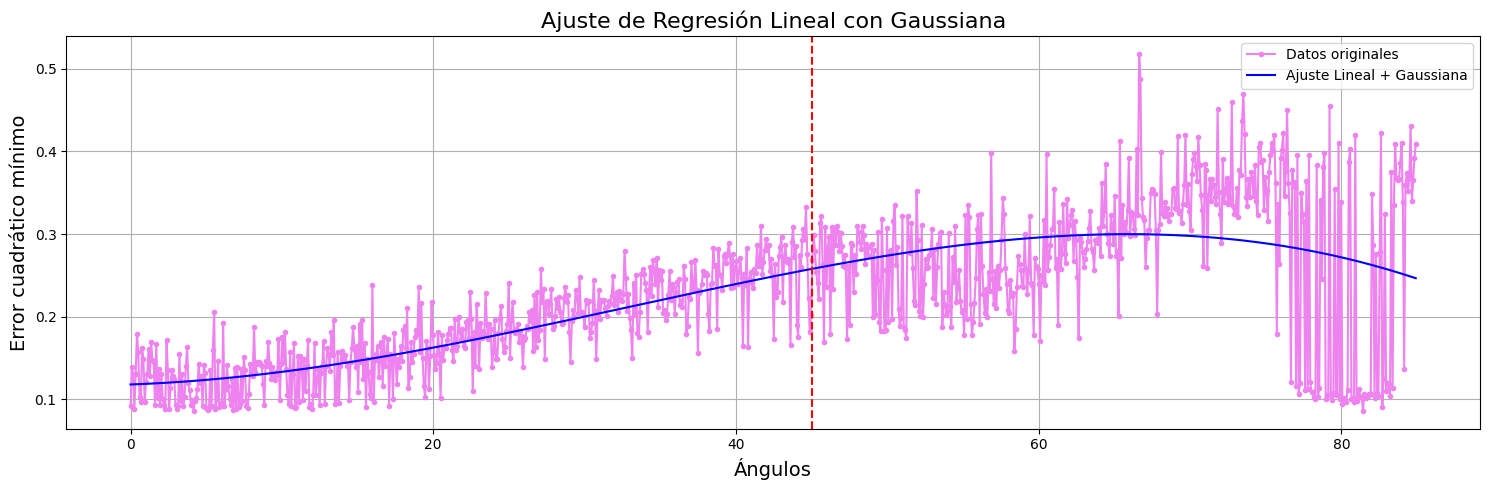

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Función de regresión lineal
def linear(x, m, b):
    return m * x + b

# Función gaussiana
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Combina la regresión lineal con una gaussiana
def quadratic_gaussian(x, m, b, a, x0, sigma):
    return linear(x, m, b) + gaussian(x, a, x0, sigma)

# Ajustar la combinación de regresión lineal y gaussiana a los datos
popt, _ = curve_fit(linear_gaussian, Angles, Error, p0=[0, 0.1, 0.1, 45, 10])

# Nuevos puntos para graficar la curva ajustada
Angles_new = np.linspace(Angles.min(), Angles.max(), 300)
Error_new = linear_gaussian(Angles_new, *popt)

# Graficar los puntos originales y la curva ajustada
plt.figure(figsize=(15, 5))
plt.plot(Angles, Error, ".-", color="violet", label="Datos originales")
plt.plot(Angles_new, Error_new, "-", color="blue", label="Ajuste Lineal + Gaussiana")

# Añadir detalles a la gráfica
plt.xlabel("Ángulos", fontsize=14)
plt.ylabel("Error cuadrático mínimo", fontsize=14)
plt.axvline(x=45, linestyle='--', color='Red')
plt.title("Ajuste de Regresión Lineal con Gaussiana", fontsize=16)
plt.grid(True)
plt.legend()

plt.show()


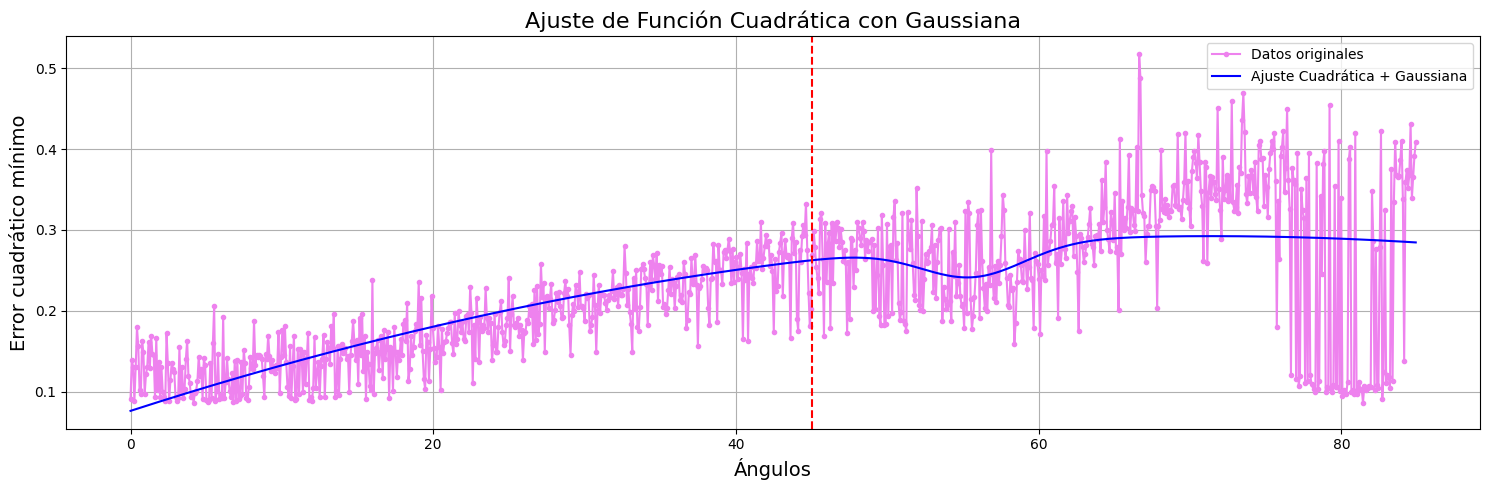

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Función cuadrática
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

# Función gaussiana
def gaussian(x, A, x0, sigma):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Combina la función cuadrática con una gaussiana
def quadratic_gaussian(x, a, b, c, A, x0, sigma):
    return quadratic(x, a, b, c) + gaussian(x, A, x0, sigma)

# Ajustar la combinación de cuadrática y gaussiana a los datos
popt, _ = curve_fit(quadratic_gaussian, Angles, Error, p0=[0.1, 3, 0.1, 0.1, 45, 10])

# Nuevos puntos para graficar la curva ajustada
Angles_new = np.linspace(Angles.min(), Angles.max(), 1000)
Error_new = quadratic_gaussian(Angles_new, *popt)

# Graficar los puntos originales y la curva ajustada
plt.figure(figsize=(15, 5))
plt.plot(Angles, Error, ".-", color="violet", label="Datos originales")
plt.plot(Angles_new, Error_new, "-", color="blue", label="Ajuste Cuadrática + Gaussiana")

# Añadir detalles a la gráfica
plt.xlabel("Ángulos", fontsize=14)
plt.ylabel("Error cuadrático mínimo", fontsize=14)
plt.axvline(x=45, linestyle='--', color='Red')
plt.title("Ajuste de Función Cuadrática con Gaussiana", fontsize=16)
plt.grid(True)
plt.legend()

plt.show()


In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Función cuadrática con corrimiento x0
def quadratic(x, a, b, c, x0):
    return a * (x - x0)**2 + b * (x - x0) + c

# Función gaussiana
def gaussian(x, A, x0_gauss, sigma):
    return A * np.exp(-(x - x0_gauss)**2 / (2 * sigma**2))

# Combina la función cuadrática con una gaussiana
def quadratic_gaussian(x, a, b, c, x0_quad, A, x0_gauss, sigma):
    return quadratic(x, a, b, c, x0_quad) + gaussian(x, A, x0_gauss, sigma)

# Ajustar la combinación de cuadrática y gaussiana a los datos
popt, _ = curve_fit(quadratic_gaussian, Angles, Error, p0=[-0.5, 8, 0.1, 70, 1, 45, 1])

# Graficar los puntos originales y la curva ajustada
plt.figure(figsize=(15, 5))
plt.plot(Angles, Error, "o", color="violet", label="Datos originales")
plt.plot(Angles, quadratic_gaussian(Angles, *popt), "-", color="blue", label="Ajuste Cuadrática + Gaussiana")

# Añadir detalles a la gráfica
plt.xlabel("Ángulos", fontsize=14)
plt.ylabel("Error cuadrático mínimo", fontsize=14)
plt.axvline(x=45, linestyle='--', color='Red')
plt.title("Ajuste de Función Cuadrática con Gaussiana", fontsize=16)
plt.grid(True)
plt.legend()

plt.show()


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1600.

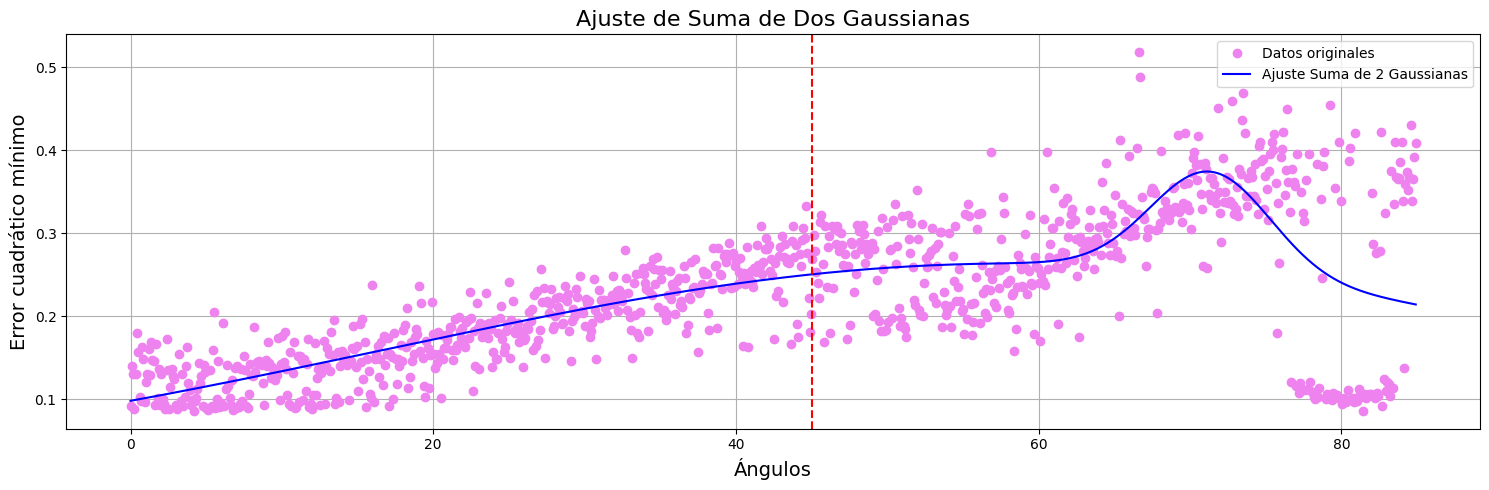

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Función que suma dos gaussianas
def double_gaussian(x, A1, x01, sigma1, A2, x02, sigma2):
    gauss1 = A1 * np.exp(-(x - x01)**2 / (2 * sigma1**2))
    gauss2 = A2 * np.exp(-(x - x02)**2 / (2 * sigma2**2))
    return gauss1 + gauss2

# Ajustar la suma de dos gaussianas a los datos
popt, _ = curve_fit(double_gaussian, Angles, Error, p0=[0.5, 45, 1, 0.5, 75, 1])

# Graficar los puntos originales y la curva ajustada
plt.figure(figsize=(15, 5))
plt.plot(Angles, Error, "o", color="violet", label="Datos originales")
plt.plot(Angles, double_gaussian(Angles, *popt), "-", color="blue", label="Ajuste Suma de 2 Gaussianas")

# Añadir detalles a la gráfica
plt.xlabel("Ángulos", fontsize=14)
plt.ylabel("Error cuadrático mínimo", fontsize=14)
plt.axvline(x=45, linestyle='--', color='Red')
plt.title("Ajuste de Suma de Dos Gaussianas", fontsize=16)
plt.grid(True)
plt.legend()

plt.show()


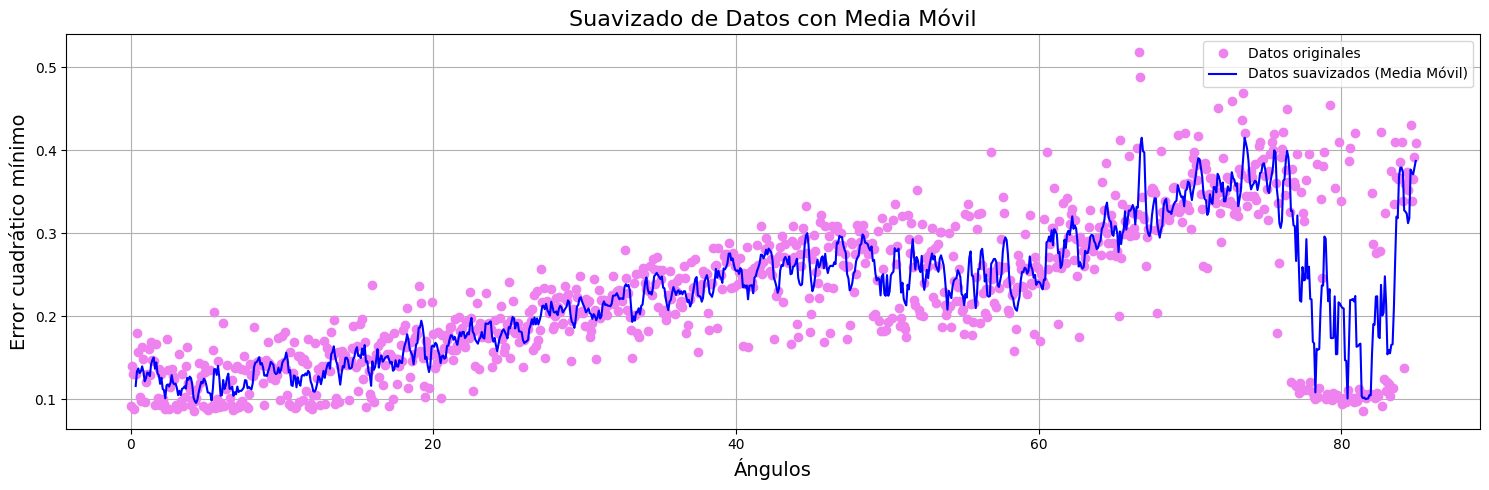

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Filtrado de Media Móvil (Moving Average)

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Ejemplo de uso
window_size = 5  # Tamaño de la ventana
smoothed_data = moving_average(Error, window_size)

# Graficar
plt.figure(figsize=(15, 5))
plt.plot(Angles, Error, "o", color="violet", label="Datos originales")
plt.plot(Angles[window_size-1:], smoothed_data, "-", color="blue", label="Datos suavizados (Media Móvil)")
plt.xlabel("Ángulos", fontsize=14)
plt.ylabel("Error cuadrático mínimo", fontsize=14)
plt.title("Suavizado de Datos con Media Móvil", fontsize=16)
plt.grid(True)
plt.legend()
plt.show()
